## Resolución SDO

# Resolución de un SDO 💡

El modelo de FitzHugh–Nagumo es un sistema de ecuaciones diferenciales ordinarias no lineales que describe la activación y desactivación de una neurona.

$$
\begin{cases}
\displaystyle \frac{dv}{dt} = v - \frac{v^3}{3} - w + I, \\[10pt]
\displaystyle \frac{dw}{dt} = \varepsilon (v + a - b w), \quad t \in [0,100],
\end{cases}
$$

donde:
* $v(t)$ representa el potencial de membrana,
* $ w(t)$ es una variable de recuperación,
* $I $ es una corriente externa aplicada,
* $\varepsilon$, $ a $, y $ b $ son parámetros positivos del modelo.

Las condiciones iniciales asociadas al sistema son:
$$
v(0) = v_0, \quad w(0) = w_0.
$$

A continuación, definimos el código utilizando *PyTorch*:

In [214]:
# Importar librerias
import numpy as np                                # Librería de cálculo numérico
import matplotlib.pyplot as plt                   # Librería de gráficos
from matplotlib.animation import FuncAnimation    # Librería para crear animaciones en gráficos generados con Matplotlib
from matplotlib.animation import FFMpegWriter     # Librería para guardar animaciones en formato vídeo
import torch
import torch.nn as nn                             # Librería de redes neuronales
import torch.optim as optim                       # Optimizador para entrenar la red neuronal y modificar sus pesos
import torch.nn.init as init                      # Inicializar los parámetros de los modelos de redes neuronales
import torch.autograd as grad                     # Cálculo automático de gradientes
import time                                       # Funciones para medir tiempos de ejecución
from scipy.integrate import solve_ivp             # Librería para resolver sistemas de ecuaciones diferenciales ordinarias (ODEs)
import math                                       # Librería da acceso a funciones elementales (trigonometría, exponenciales, etc.) y constantes matemáticas

### Datos

In [215]:
epsilon = 0.08
a = 0.7
b = 0.8
I = 0.5
N = 3000
print_freq = 2000 # imprimir cada epoca

# Condiciones iniciales
v0 = -1.0
w0 = 1.0
y0 = [v0, w0]

# Intervalo de tiempo para la simulación
t_span = (0, 100)                                 # de 0 a 100 unidades de tiempo
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # puntos donde evaluamos la solución

### -> solve_ivp

In [216]:
def fitzhugh_nagumo(t, y):
    v, w = y
    dvdt = v - (v**3)/3 - w + I
    dwdt = epsilon * (v + a - b*w)
    return [dvdt, dwdt]

# Resolver el sistema
sol = solve_ivp(fitzhugh_nagumo, t_span, y0, t_eval=t_eval, method='RK45')

### Resolución y representación gráfica

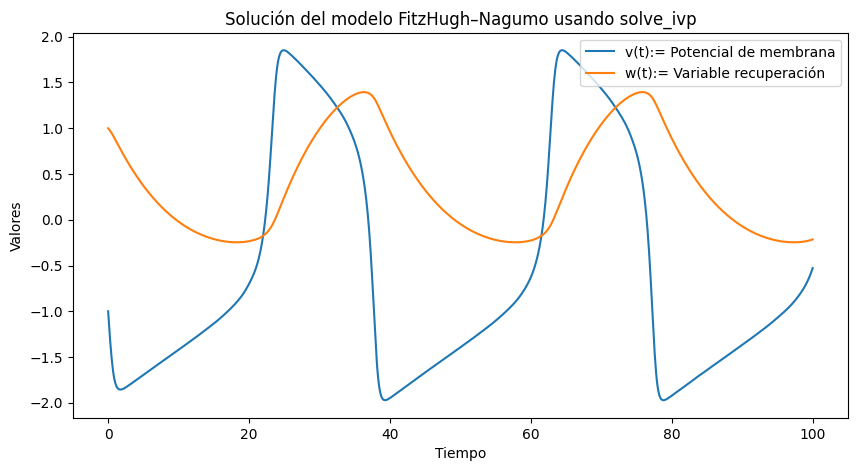

In [217]:
# Graficar resultados
plt.figure(figsize=(10,5))
plt.plot(sol.t, sol.y[0], label='v(t):= Potencial de membrana')
plt.plot(sol.t, sol.y[1], label='w(t):= Variable recuperación')
plt.title('Solución del modelo FitzHugh–Nagumo usando solve_ivp')
plt.xlabel('Tiempo')
plt.ylabel('Valores')
plt.legend()
plt.show()

###Definición red neuronal

In [218]:
# Fijamos la semilla
torch.manual_seed(1234)
np.random.seed(1234)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


In [219]:
# Definición de Red Neuronal de Propagación Adelante (Feedforward)

class PINN(nn.Module):                                           # Clase PINN es una subclase de nn.Module

    def __init__(self, input_size, hidden_size, output_size):    # Constructor que se ejecuta cuando se crea una instancia de la clase PINN
                                                                 # Este método inicializa las capas de la red neuronal
        super(PINN, self).__init__()                             # Llama al constructor de la clase base nn.Module


        # Capas de la red neuronal (4 capas lineales: nn.Linear)

        # Estas capas representan las conexiones ponderadas entre las neuronas de capas consecutivas.
        #  nn.Linear(input_size, hidden_size)
        #  input_size : es la cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: la cantidad de salidas (neuronas en la capa actual)
        # Capa lineal => Salida = Entradas × Pesos + Sesgo

        # Capa 1: Recibe input_size características como entrada y produce hidden_size características como salida
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Entrada con hidden_size características, salida con hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Capa 3: Entrada con hidden_size características, salida con hidden_size características
        self.fc3 = nn.Linear(hidden_size, hidden_size)

        # Capa 4: Entrada con hidden_size características, salida con hidden_size características
        self.fc4 = nn.Linear(hidden_size, hidden_size)

        # Capa 5: Entrada con hidden_size características, salida con 1 característica
        self.fc5 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos (I): Random Initialization
        # Inicializar los pesos de las capas con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Distribución normal
        # o
        # nn.init.uniform_(layer.weight, a=0, b=1)           # Distribución uniforme

        # Inicialización de pesos (II): Xavier/Glorot Initialization
        # Diseñada para su uso con funciones de activación como la tangente hiperbólica o la función logística (sigmoid)
        # Ayuda a mantener una varianza constante a través de las capas
        ## Sale mejor en este ejemplo que sin dicha inicializacion
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.xavier_normal_(self.fc5.weight)

        # Inicialización de pesos (III):  LeCun Initialization:
        # Inicialización propuesta por LeCun para funciones de activación como la tangente hiperbólica
        # nn.init.normal_(layer.weight, mean=0, std=np.sqrt(1 / layer.weight.shape[0]))
        # init.normal_(self.fc1.weight, mean=0, std=np.sqrt(1 / self.fc1.weight.shape[0]))
        # init.normal_(self.fc2.weight, mean=0, std=np.sqrt(1 / self.fc2.weight.shape[0]))
        # init.normal_(self.fc3.weight, mean=0, std=np.sqrt(1 / self.fc3.weight.shape[0]))
        # init.normal_(self.fc4.weight, mean=0, std=np.sqrt(1 / self.fc3.weight.shape[0]))
        # init.normal_(self.fc5.weight, mean=0, std=np.sqrt(1 / self.fc3.weight.shape[0]))

    def forward(self, x):
       # En este caso, el método forward toma la entrada x y la pasa a través de las capas fc1, fc2, fc3, fc4 y fc5
       # utilizando la función de activación tangente hiperbólica (torch.tanh) después de las dos primeras capas.
       # La última capa (fc3) no tiene una función de activación
       x = torch.tanh(self.fc1(x))
       x = torch.tanh(self.fc2(x))
       x = torch.tanh(self.fc3(x))
       x = torch.tanh(self.fc4(x))
       x = self.fc5(x)             # No aplicamos función de activación en la última capa fc5

       # Aplicacion a la sigmoide
       #x = torch.sigmoid(self.fc1(x))
       #x = torch.sigmoid(self.fc2(x))
       #x = torch.sigmoid(self.fc3(x))
       #x = torch.sigmoid(self.fc4(x))
       #x = self.fc5(x)

       return x

###Datos entrenamiento

In [220]:
print(sol.t.shape)
print(sol.y.shape)

t = sol.t[::1]
y = sol.y[::1]
t = torch.Tensor(sol.t).view(-1,1)       # (N, 1)
y = torch.Tensor(sol.y.T)
t.shape
y.shape
y

(1000,)
(2, 1000)


tensor([[-1.0000,  1.0000],
        [-1.1159,  0.9908],
        [-1.2277,  0.9806],
        ...,
        [-0.5730, -0.2199],
        [-0.5513, -0.2173],
        [-0.5284, -0.2147]])

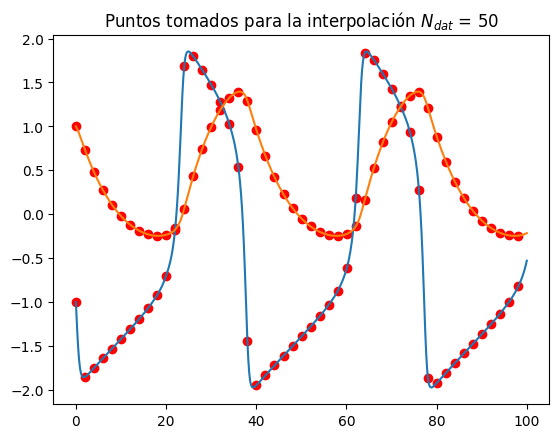

In [221]:
k = 150
#k = 180
#k = 14
#k = 100
n = math.ceil(N/k) # redondeo hacia arriba
n


# Vamos a tomar 26 datos para el entrenamiento

#t_data = t[::119]
#y_data = y[::119]
# Tomamos 11, peor que 26
#t_data = t[::300]
#y_data = y[::300]

# Tomamos k
t_data = t[::n]
y_data = y[::n]


t_data.shape, y_data.shape
#y_data
#t.shape, y.shape

(torch.Size([21, 1]), torch.Size([21, 2]))

plt.figure()
plt.plot(t,y)
plt.scatter(t_data,y_data[:,0], c="red")
plt.scatter(t_data,y_data[:,1], c="red")
plt.title(f"Puntos tomados para la interpolación $N_{{dat}}$ = {len(y_data)}")
plt.show()

### Entrenamiento red neuronal

In [222]:
# Función de entrenamiento
def train(model, optimizer,loss_fn, t_data, y_data, num_epochs):

  learning_rates = []                             # Lista --> almacena los learning rates en cada iteración/época
  loss_history = []                               # Lista --> almacena la pérdida en cada época


  for epoca in range(num_epochs):                 # Bucle de entrenamiento

    # Calcular las predicciones de la red y las derivadas
    model.train()                                 # Activación del modo de entrenamiento de la red

    y = model(t_data)                             # Predicciones de la red


    # Calcular la pérdida entre predicciones y datos reales
    loss = loss_fn(y, y_data)

    # Optimización
    optimizer.zero_grad()                         # Se ponen a cero los gradientes acumulados en los tensores del modelo
    loss.backward()                               # Se realiza la retropropagación backward
    optimizer.step()                              # Se actualizan los parámetros del modelo mediante el optimizador (optimizer)

    loss_history.append(loss.item())              # Almacenamiento de la pérdida (error)


    current_lr = optimizer.param_groups[0]['lr']  # Obtiene learning rate actual
    learning_rates.append(current_lr)             # Almacenamiento del learning rate

    # Imprimir el progreso
    if (epoca + 1) % print_freq == 0:
      print(f'Epoch [{epoca+1}/{num_epochs}], Total Loss: {loss.item()}')

  return loss_history, learning_rates, y         # Lista de la pérdida y el lerning rate al final del entrenamiento

In [223]:
# Instancia del modelo y del optimizador

# Creación del modelo con los parámetros definidos
# model = PINN(input_size, hidden_size, output_size)
# Necesitamos como datos de entrada:
# - input_size
# - hidden_size
# - output_size

# Parámetros del modelo
input_size = 1            # Número de entradas de la red
hidden_size = 60          # Número de neuronas en la capa oculta
#hidden_size = 60         # Opciones alternativas del tamaño de la capa oculta
#hidden_size = 200
output_size = 2           # Número de salidas de la red

# Tasa de aprendizaje
learnig_rate = 0.001
# learnig_rate = 0.01

model = PINN(input_size, hidden_size, output_size)

# Definición del optimizador para la actualización de los pesos de la red
optimizer = optim.Adam(model.parameters(), lr = learnig_rate)

# Función de pérdida para calcular el error de la red
loss_fn = nn.MSELoss()

start_time = time.time()   # Tiempo de inicio

# Número de iteraciones:
num_epoch = 20000
#num_epoch = 40000         # Otras opciones
#num_epoch = 15000
#num_epoch = 35000
#num_epoch = 48000
#num_epoch = 22000
#num_epoch = 10000
#num_epoch = 1000000       # Muchísimas épocas (no recomendable en muchos casos)
#num_epoch = 5000

# Entrenamos el modelo utilizando la función de entrenamiento
loss_history, learning_rates, y = train(model, optimizer, loss_fn,t_data, y_data, num_epoch)

end_time = time.time()     # Tiempo de finalización

# Calculamos el tiempo transcurrido durante el entrenamiento
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

Epoch [2000/20000], Total Loss: 0.00661226874217391
Epoch [4000/20000], Total Loss: 0.00010558813664829358
Epoch [6000/20000], Total Loss: 4.9343394493917e-05
Epoch [8000/20000], Total Loss: 2.659918027347885e-05
Epoch [10000/20000], Total Loss: 2.230821155535523e-05
Epoch [12000/20000], Total Loss: 0.00022157520288601518
Epoch [14000/20000], Total Loss: 0.00010843376367120072
Epoch [16000/20000], Total Loss: 1.286682345380541e-05
Epoch [18000/20000], Total Loss: 2.6908355721388943e-05
Epoch [20000/20000], Total Loss: 9.437717380933464e-06
 
Tiempo de ejecución: 22.274008750915527 segundos


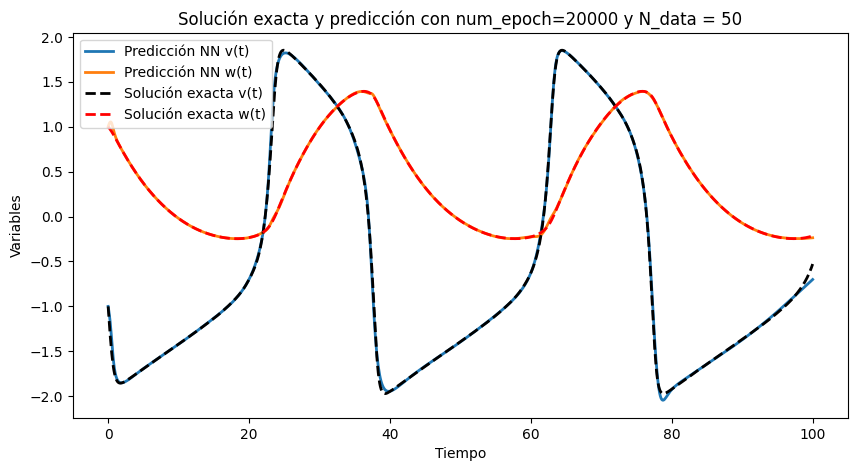

In [224]:
yh = model(t).detach()
yh
yh.shape

plt.figure(figsize=(10,5))
plt.plot(sol.t, yh[:,0], linewidth=2, label="Predicción NN v(t)")
plt.plot(sol.t, yh[:,1], linewidth=2, label="Predicción NN w(t)")
plt.plot(sol.t, sol.y[0,:], 'k--', linewidth=2, label='Solución exacta v(t)')
plt.plot(sol.t, sol.y[1,:], 'r--', linewidth=2, label='Solución exacta w(t)')
plt.legend()
plt.title(f'Solución exacta y predicción con num_epoch={num_epoch} y N_data = {len(y_data)}')
plt.xlabel('Tiempo')
plt.ylabel('Variables')
plt.show()

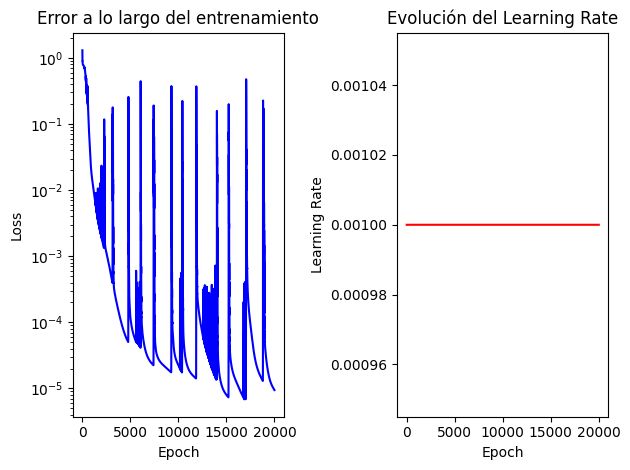

In [225]:
# Crear una figura con dos subgráficas
plt.figure()
plt.subplot(1,2,1)
# Graficar la evolución de la pérdida
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Error a lo largo del entrenamiento')
plt.yscale('log')

plt.subplot(1,2,2)
# Graficar la evolución del learning rate
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='red')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')


# Ajustar el diseño y mostrar la gráfica
plt.tight_layout()
plt.show()